In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch
from scipy.stats import circstd

from kalman_experiments import SSPE
from kalman_experiments.kalman.onedim import SossAugSmoother, apply_kf
from kalman_experiments.model_selection import (
    estimate_sigmas_squared,
    fit_kf_parameters,
    get_psd_val_from_est,
    theor_psd_ar,
    theor_psd_mk_mar,
)
from kalman_experiments.models import (
    ArNoise,
    MatsudaParams,
    SingleRhythmModel,
    collect,
    gen_ar_noise_coefficients,
)
from kalman_experiments.numpy_types import (
    check_in_alpha_range,
    check_nonnegative_float,
    check_positive_float,
    check_positive_int,
)

SR = check_positive_float(500)
DURATION = 1000
n_samp = check_positive_int(int(DURATION * SR))
FREQ_GT = check_nonnegative_float(6)
SIGNAL_SIGMA_GT = check_nonnegative_float(np.sqrt(10))
NOISE_SIGMA_GT = check_nonnegative_float(1)
A_GT = check_nonnegative_float(0.99)
ALPHA = check_in_alpha_range(1.5)
NOISE_AR_ORDER = check_positive_int(1000)

data = {}
phases = {}
gt = {}

data["sines_in_white"], gt["sines_in_white"], phases["sines_in_white"] = SSPE.gen_sine_w_white(
    DURATION, SR
)
data["sines_in_pink"], gt["sines_in_pink"], phases["sines_in_pink"] = SSPE.gen_sine_w_pink(
    DURATION, SR
)
(
    data["filtered_pink"],
    gt["filtered_pink"],
    phases["filtered_pink"],
) = SSPE.gen_filt_pink_noise_w_added_pink_noise(DURATION, SR)

mp = MatsudaParams(A_GT, FREQ_GT, SR)
oscillation_model = SingleRhythmModel(mp, sigma=SIGNAL_SIGMA_GT)
gt_states = collect(oscillation_model, n_samp)

noise_model = ArNoise(
    x0=np.random.rand(NOISE_AR_ORDER), alpha=ALPHA, order=NOISE_AR_ORDER, s=NOISE_SIGMA_GT
)
noise_sim = collect(noise_model, n_samp)
pink_noise_sspe = SSPE.make_pink_noise(ALPHA, n_samp, 1 / SR)
white_noise_sspe = NOISE_SIGMA_GT * np.random.randn(n_samp)
data["state_space_model_white"] = np.real(gt_states).copy() + white_noise_sspe
data["state_space_model_pink"] = np.real(gt_states).copy() + noise_sim
# data["state_space_model"] = np.real(gt_states) + noise_sim
# data["state_space_model"] = np.real(gt_states) + 10 * pink_noise_sspe # NOISE_SIGMA_GT * SSPE.make_pink_noise(ALPHA, DURATION * SR, 1/SR)
phases["state_space_model_white"] = np.angle(gt_states.copy())  # type: ignore
phases["state_space_model_pink"] = np.angle(gt_states.copy())  # type: ignore

In [ ]:
# Setup filters

A_KF = check_nonnegative_float(0.99)
FREQ_KF = check_nonnegative_float(6)
SIGNAL_SIGMA_KF = SIGNAL_SIGMA_GT
NOISE_SIGMA_KF = NOISE_SIGMA_GT

# kf = Difference1DMatsudaKF(A=A_KF, f=FREQ_KF, sr=SR, q_s=SIGNAL_SIGMA_KF, psi=PSI, r_s=NOISE_SIGMA_KF)
# kf = PerturbedP1DMatsudaKF(
#     A=A_KF, f=FREQ_KF, sr=SR, q_s=SIGNAL_SIGMA_KF, psi=noise_model.a, r_s=NOISE_SIGMA_KF, lambda_=0
# )
a = gen_ar_noise_coefficients(alpha=ALPHA, order=check_positive_int(30))
mp = MatsudaParams(A_KF, FREQ_KF, SR)
kf_pink = SossAugSmoother(
    mp, q_s=SIGNAL_SIGMA_KF, psi=a, r_s=check_nonnegative_float(NOISE_SIGMA_KF * 5), lambda_=0
)
kf_white = SossAugSmoother(
    mp,
    q_s=SIGNAL_SIGMA_KF,
    psi=np.array([0]),
    r_s=check_nonnegative_float(NOISE_SIGMA_KF * 5),
    lambda_=0,
)

qs, rs = {}, {}
qs["sines_in_white"] = {"white": 0.3, "pink": 0.3}
qs["sines_in_pink"] = {"white": 0.3, "pink": 0.2}
qs["filtered_pink"] = {"white": 0.4, "pink": 0.3}
qs["state_space_model_white"] = {"white": NOISE_SIGMA_GT, "pink": SIGNAL_SIGMA_GT}
qs["state_space_model_pink"] = {"white": SIGNAL_SIGMA_GT, "pink": SIGNAL_SIGMA_GT}

rs["sines_in_white"] = {"white": 1, "pink": 1}
rs["sines_in_pink"] = {"white": 0.1, "pink": 0.2}
rs["filtered_pink"] = {"white": 0.1, "pink": 0.2}
rs["state_space_model_white"] = {"white": NOISE_SIGMA_GT, "pink": NOISE_SIGMA_GT}
rs["state_space_model_pink"] = {"white": NOISE_SIGMA_GT, "pink": NOISE_SIGMA_GT}

                   Pink KF White KF
state_space_model_pink 2.97103202934944 1.3946467166457213


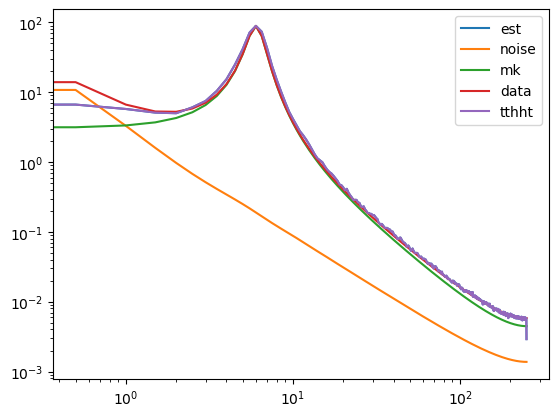

Fitting KF parameters:   0%|                                    | 0/800 [00:00<?, ?it/s]

nll =  17351.117571345363


Fitting KF parameters:   0%|                                    | 0/800 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [3]:
def to_db(arr):
    return 10 * np.log10(arr)


print(" " * 18, "Pink KF", "White KF")
factors = []
pink_kf_cstd = []
white_kf_cstd = []
for k in data:
    if k != "state_space_model_pink":
        continue
    ff, psd = welch(data[k], fs=SR, nperseg=1000)
    data_psd_func = partial(get_psd_val_from_est, freqs=ff, psd=psd / 2)
    basis_psd_funcs = [
        partial(
            theor_psd_mk_mar,
            mp=MatsudaParams(freq_hz=FREQ_GT, A=A_GT, sr=SR),
            s=check_nonnegative_float(1),
        ),
        partial(theor_psd_ar, ar_coef=kf_pink.psi, sr=SR, s=check_nonnegative_float(1)),
    ]

    # freqs = [3, 6, 9, 12, 15, 18, 21]
    freqs = [check_positive_float(f) for f in [6, 100, 200]]
    q_s_2, r_s_2 = estimate_sigmas_squared(basis_psd_funcs, data_psd_func, freqs)
    print(k, np.sqrt(q_s_2 * SR), np.sqrt(r_s_2 * SR))
    fig = plt.figure()
    plt.loglog(ff, (psd / 2), label="est")
    plt.loglog(ff, (np.array([basis_psd_funcs[1](f) * r_s_2 for f in ff])), label="noise")
    plt.loglog(ff, (np.array([basis_psd_funcs[0](f) * q_s_2 for f in ff])), label="mk")
    plt.loglog(
        ff,
        (np.array([basis_psd_funcs[0](f) * q_s_2 + basis_psd_funcs[1](f) * r_s_2 for f in ff])),
        label="data",
    )
    plt.loglog(ff, (np.array([data_psd_func(f) for f in ff])), label="tthht")
    plt.legend()
    plt.show()

    kf_pink = SossAugSmoother(
#         mp, q_s=np.sqrt(q_s_2 * SR), psi=a, r_s=np.sqrt(r_s_2 * SR), lambda_=0
        mp, q_s=np.sqrt(q_s_2 * SR), psi=a, r_s=1, lambda_=1e-6
    )
    kf_pink.q_s = np.sqrt(q_s_2 * SR)
    kf_pink.r_s = np.sqrt(r_s_2 * SR)
    kf_pink_fit = fit_kf_parameters(data[k][:10000], kf_pink, tol=1e-5)
    print("kf_pink_params: ", kf_pink_fit.mp, kf_pink_fit.q_s, kf_pink_fit.r_s)
    print()
    print()
    print()
    
    kf_white = SossAugSmoother(
        mp,
        q_s=np.sqrt(q_s_2 * SR),
        psi=np.array([0]),
        r_s=np.sqrt(r_s_2 * SR),
        lambda_=0,
    )
    kf_white_fit = fit_kf_parameters(data[k][:10000], kf_white, tol=1e-5)
    print("kf_white_params: ", kf_white_fit.mp, kf_white_fit.q_s, kf_white_fit.r_s)
    # kf_white.q_s = qs[k]["white"]
    # kf_white.r_s = rs[k]["white"]
    # kf_white_fit = fit_kf_parameters(data[k][:5000], kf_white)
    # print("kf_white_params: ", kf_white_fit.M, kf_white_fit.q_s, kf_white_fit.r_s)
    # filtered_pink = apply_kf(kf_pink_fit, data[k], delay=0)
    # filtered_white = apply_kf(kf_white_fit, data[k], delay=0)
    # cstd_pink = circstd(np.angle(filtered_pink) - phases[k])
    # cstd_white = circstd(np.angle(filtered_white) - phases[k])
    # #     print(f"{k:<18}", round(cstd_pink * 180 / np.pi, 2), round(cstd_white * 180 / np.pi,2))
    # white_kf_cstd.append(cstd_white * 180 / np.pi)
    # pink_kf_cstd.append(cstd_pink * 180 / np.pi)
    # factors.append(k)

In [ ]:
%debug

In [ ]:
r_s_2 * SR

In [ ]:
np.sqrt(kf_pink.KF.Q[2,2])

In [ ]:
np.sqrt(kf_pink_fit.KF.Q)

In [ ]:
np.sqrt(10)

In [ ]:
kf_pink.KF.R

In [4]:
from scipy.optimize import minimize
from kalman_experiments.model_selection import wrapper
from functools import partial

In [10]:
targ = partial(wrapper, meas=data[k][:10000], sr=SR, psi=a, A=0.99, f=6)

In [11]:
res = minimize(targ, x0=np.array([np.sqrt(q_s_2 * SR), np.sqrt(1)]))

In [12]:
res

      fun: 17350.844556594762
 hess_inv: array([[1., 0.],
       [0., 1.]])
      jac: array([ 8158871.15917969, 15381663.92871094])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 99
      nit: 1
     njev: 29
   status: 2
  success: False
        x: array([2.97103203, 1.        ])